## 住宅ローンのデータセット

<a href="https://www.shoeisha.co.jp/book/detail/9784798143446">アクセンチュアのプロフェッショナルが教えるデータ・アナリティクス実践講座</a>に掲載の例。

データセットは
https://enterprisezine.jp/iti/detail/6873
に掲載の
<a href="https://ez-cdn.shoeisha.jp/static/images/article/6873/flat35_research_2013.csv">flat35_research_2013.csv</a>
を使用。

<hr>

### クラスタリングによる地域ごとの特性の分析

住宅ローン（フラット35：長期固定金利住宅ローン）を借りる顧客について、地域ごとに顧客や住宅の属性にどのような違いがあるのかを分析する。

- 融資担当者は、地域ごとの特性を、融資の提案や金融商品の開発に活かせる（かもしれない）。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

# matplotlib: 日本語フォントの設定（MacOS）
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 
                               'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

flat35 = pd.read_csv('data/flat35_research_2013.csv')

# データの確認
flat35.head()

,都道府県,年齢,家族数,世帯の年収,住宅面積,所要資金額
0,北海道,38.4,3.4,524.7,121.6,2758.4
1,青森県,40.1,3.7,549.1,128.1,2731.8
2,岩手県,39.7,3.8,550.1,124.6,2787.5
3,宮城県,40.9,3.7,588.0,120.1,3151.6
4,秋田県,40.9,3.5,480.2,120.3,2437.2


In [2]:
# 都道府県をインデックスラベルにする
df = flat35.set_index('都道府県')
# 確認
df.head()

,年齢,家族数,世帯の年収,住宅面積,所要資金額
都道府県,,,,,
北海道,38.4,3.4,524.7,121.6,2758.4
青森県,40.1,3.7,549.1,128.1,2731.8
岩手県,39.7,3.8,550.1,124.6,2787.5
宮城県,40.9,3.7,588.0,120.1,3151.6
秋田県,40.9,3.5,480.2,120.3,2437.2


各列のデータは値が大きく異なるため、このままではクラスタリングには不向き。
- 値の大きいデータの影響が大きい

データの標準化
- 分布を標準偏差をもとに調整
- 平均値が0、標準偏差が1となるように変換

In [3]:
# データの標準化
sc = StandardScaler()
sc.fit(df)

# 標準化したデータの DataFrame を作成
# - 行列ラベルは元のままを使用
X = pd.DataFrame(sc.transform(df), index=df.index, columns=df.columns)

# 確認
X.head()

,年齢,家族数,世帯の年収,住宅面積,所要資金額
都道府県,,,,,
北海道,-0.665695,-0.293965,-0.636132,0.508912,-0.733234
青森県,0.867130,1.241185,-0.219765,1.176750,-0.820742
岩手県,0.506465,1.752902,-0.202701,0.817145,-0.637503
宮城県,1.588459,1.241185,0.444032,0.354796,0.560292
秋田県,1.588459,0.217752,-1.395489,0.375345,-1.789900


In [4]:
# 出力の表記を設定
# - pd.options.display.float_format: 小数点以下の表示方法を指定
pd.options.display.float_format = '{:.2f}'.format

# 代表値を確認
X.describe()

,年齢,家族数,世帯の年収,住宅面積,所要資金額
count,47.00,47.00,47.00,47.00,47.00
mean,0.00,-0.00,0.00,-0.00,0.00
std,1.01,1.01,1.01,1.01,1.01
min,-2.02,-2.34,-1.83,-3.31,-1.79
25%,-0.67,-0.29,-0.61,-0.34,-0.60
50%,-0.12,0.22,-0.11,0.17,-0.09
75%,0.87,0.22,0.42,0.57,0.50
max,1.77,2.26,3.30,1.85,4.20


<hr>

### 階層的凝集クラスタリング

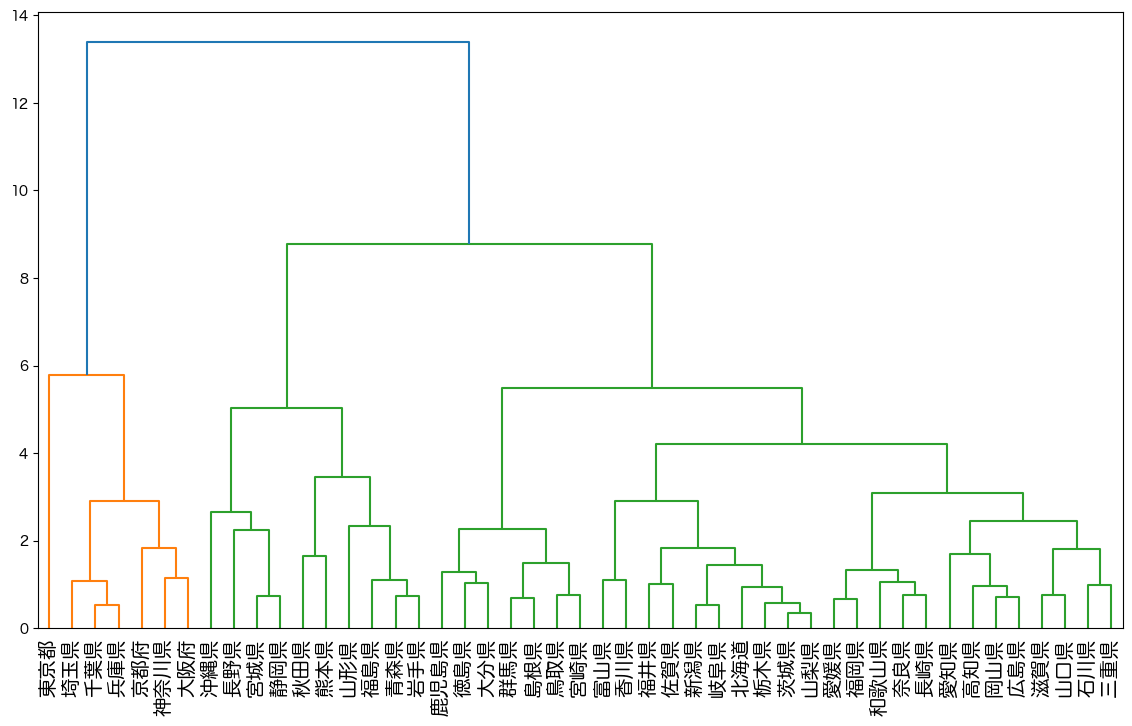

In [5]:
# 階層的凝集クラスタリング
# - method='ward' Ward法
clusters = linkage(X.values, method='ward', metric='euclidean')

# 樹形図を作成
plt.figure(figsize=(14, 8))
dendr = dendrogram(clusters, labels=df.index, leaf_font_size=14)

### ヒートマップ

- このようなクラスタ階層になる理由
- 各データの特徴
- 適切なクラスタ数

を把握するため、データの全体的な特徴を見ることのできるヒートマップを付けて、表示する。ヒートマップでは、小さい値は濃く、大きい値は薄く白に近い色で表示される。

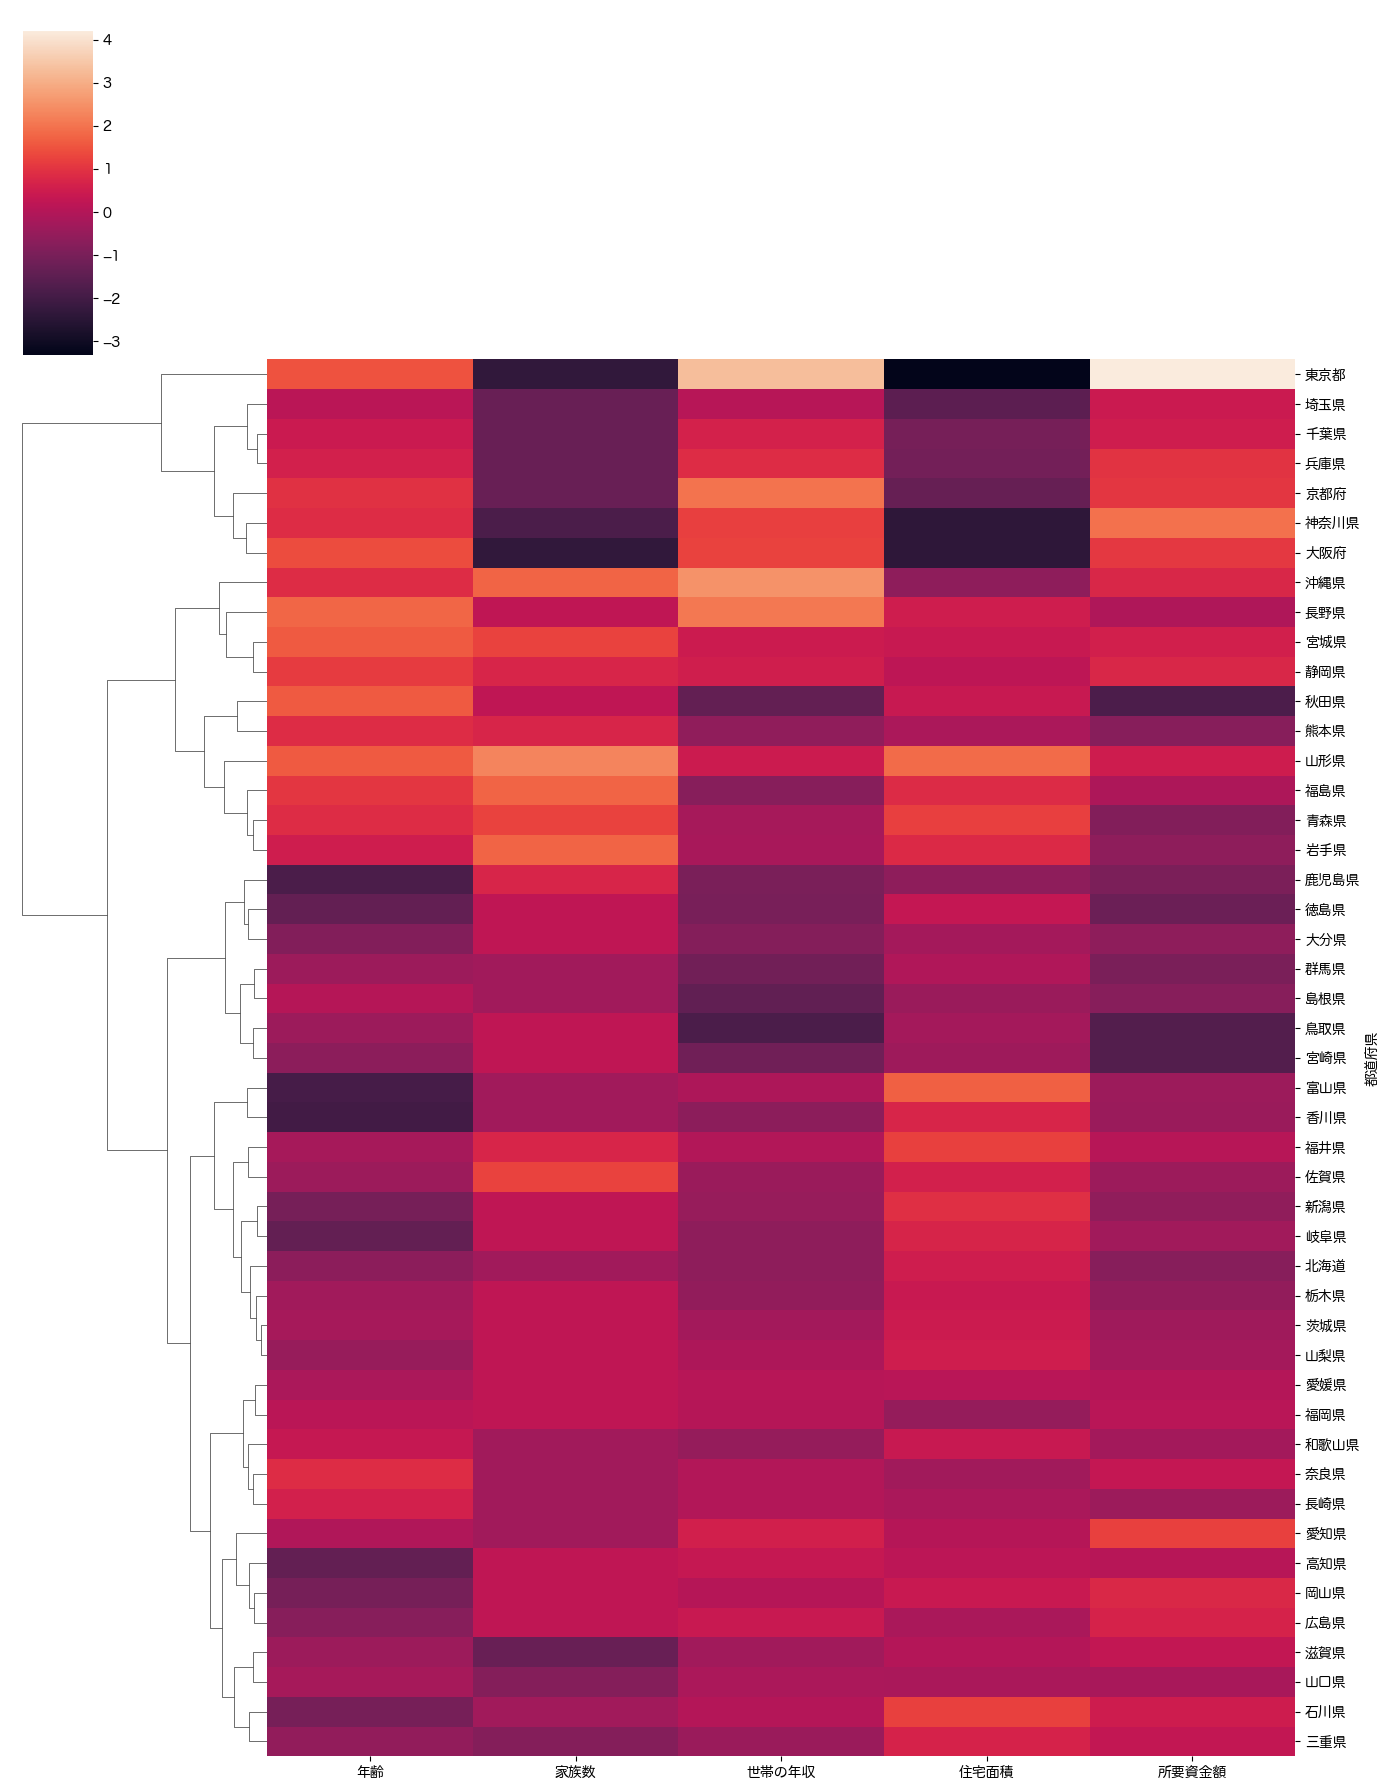

In [7]:
# ヒートマップ付きの樹形図を作成
sns.clustermap(X, method='ward', metric='euclidean', figsize=(14, 18), col_cluster=False)

### クラスタごとの平均値（クラスタ平均）

In [8]:
# 階層的凝集クラスタリング
# - method='ward' Ward法
clusters = linkage(X.values, method='ward', metric='euclidean')

from scipy.cluster.hierarchy import cut_tree
# cut_tree: 指定したクラスタ数でのラベル（クラスタ番号）を取得
# - np.ndarray.flatten: cut_tree は多次元配列で返すので、1次元配列に変換
labels = np.ndarray.flatten(cut_tree(clusters, 2))

# クラスタ番号を結合したDataFrameを作成
df_cluster = pd.concat([df, pd.DataFrame(labels, index=X.index, columns=['cluster'])], axis=1)

# クラスタごとの平均値
df_cluster.groupby('cluster').mean()

,年齢,家族数,世帯の年収,住宅面積,所要資金額
cluster,,,,,
0,38.98,3.51,548.35,119.83,2903.98
1,40.07,3.13,639.87,98.46,3423.00


In [9]:
# cut_tree: 指定したクラスタ数でのラベル（クラスタ番号）を取得
labels = np.ndarray.flatten(cut_tree(clusters, 3))

# クラスタ番号を結合したDataFrameを作成
df_cluster = pd.concat([df, pd.DataFrame(labels, index=X.index, columns=['cluster'])], axis=1)

# クラスタごとの平均値
df_cluster.groupby('cluster').mean()

,年齢,家族数,世帯の年収,住宅面積,所要資金額
cluster,,,,,
0,38.48,3.46,538.18,119.16,2894.59
1,40.45,3.69,578.85,121.84,2932.16
2,40.07,3.13,639.87,98.46,3423.00


### クラスタ数

樹形図の枝の長さからは、2か3のところで切るのが適当。

### クラスタ数を2とする場合の特徴

1. 東京都、埼玉県、千葉県、兵庫県、京都府、神奈川県、大阪府<br>
家族数と住宅面積が小さい。年齢、世帯の年収、所要資金額が大きい。
2. 1以外の都道府県<br>
家族数と住宅面積が大きい。年齢、世帯の年収、所要資金額が小さい。

### クラスタ数を3とする場合の特徴

1. 東京都〜大阪府<br>
年齢は中間。家族数と住宅面積が小さい。世帯の年収、所要資金額が大きい。
2. 沖縄県〜岩手県<br>
年齢、家族数、住宅面積は中間。世帯の年収、所要資金額が小さい。
3. 鹿児島県〜三重県<br>
家族数と住宅面積が大きい。年齢、世帯の年収、所要資金額が小さい。

<hr>

## 非階層的クラスタリング

- 非階層的クラスタ分析ではクラスタ数を決めてデータをグループに分割

<b>クラスタ数の推定</b>
- エルボー法
- シルエット分析

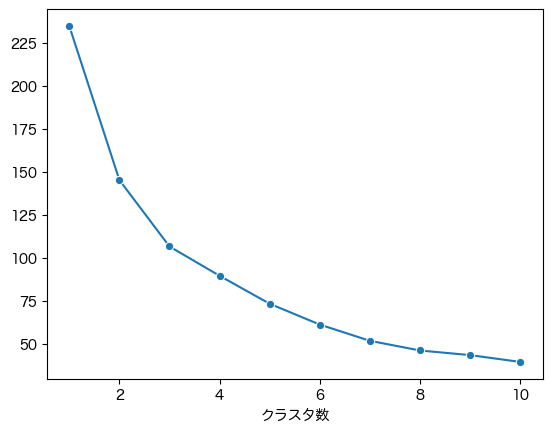

In [10]:
# エルボー法
# https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch11/ch11.py
distortions = []
for n in range(1, 11):
    model = KMeans(n_clusters=n, random_state=0)
    model.fit(X)
    distortions.append(model.inertia_)

sns.lineplot(x=range(1, 11), y=distortions, marker='o')
plt.xlabel('クラスタ数')
plt.show()

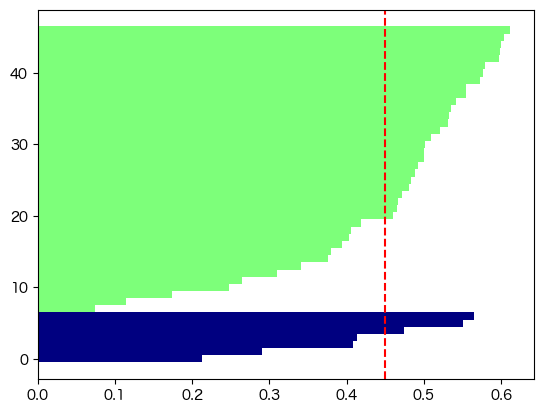

2 Clusters: Average silhouette width: 0.450


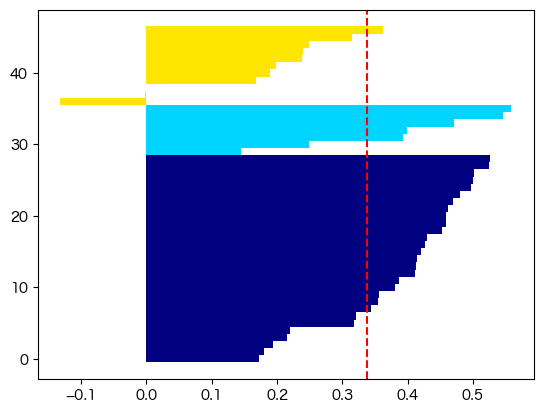

3 Clusters: Average silhouette width: 0.338


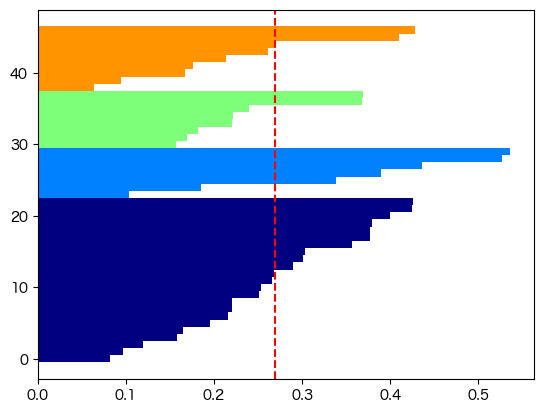

4 Clusters: Average silhouette width: 0.270


In [11]:
# シルエット分析
# https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch11/ch11.py
from sklearn.metrics import silhouette_samples
from matplotlib import cm

def silhouette(n):
    model = KMeans(n_clusters=n, random_state=0)
    model.fit(X)
    cluster_labels = set(model.labels_)
    n_clusters = len(cluster_labels)
    silhouette_vals = silhouette_samples(X, model.labels_, metric='euclidean')
    y_lower, y_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[model.labels_ == c]
        c_silhouette_vals.sort()
        y_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_lower, y_upper), c_silhouette_vals, height=1.0,
                 edgecolor='none', color=color)
        yticks.append((y_lower + y_upper) / 2.)
        y_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.show()
    print('{} Clusters: Average silhouette width: {:.3f}'.format(n, silhouette_avg))

for n in range(2, 5):
    silhouette(n)

### クラスタ数の推定結果

- エルボー法：2または3
- シルエット分析：2で平均シルエット係数が最大

クラスタ数は2が適当と考えられる。

In [ ]:
# K-means によるクラスタリング
model = KMeans(n_clusters=2)
model.fit(X)
# 各クラスタの要素をアウトプット
for n in range(0, 2):
    print('クラスタ{}：{}'.format(n, list(X[model.labels_==n].index)))

### クラスタ平均

In [ ]:
# K-means によるクラスタリング
model = KMeans(n_clusters=2)
model.fit(X)

# クラスタ番号を結合したDataFrameを作成
df_cluster = pd.concat([df, pd.DataFrame(model.labels_, index=X.index, columns=['cluster'])], axis=1)

# クラスタごとの平均値
df_cluster.groupby('cluster').mean()

<hr>

### K-means によるクラスタリングの結果

階層的凝集クラスタリングと同じ結果が得られた。

クラスタ数を2とする場合の特徴として、

- 家族数、住宅面積
- 年齢、世帯の年収、所要資金額

に大小の差がある。